In [1]:
import sys

import numpy as np
from sklearn.linear_model import LogisticRegression
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForMaskedLM,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
)

from pipelines import DNAEmbeddingPipeline, DNAClassificationPipeline
from project_utils import (
    compute_accuracy,
    create_dataset,
    compute_trainer_metrics,
    extract_embeddings_from_pipeline,
    plot_umap,
    plot_confusion_matrix,
)

sys.path.append("../")

from utils import (
    PLOTLY_AXIS_ATTR_DICT,
    PLOTLY_LEGEND_ATTR_DICT,
    save_fig,
    save_plotly,
)

# global parameters
MAX_LENGTH = 15
MODEL = "InstaDeepAI/nucleotide-transformer-v2-50m-multi-species"
DATASETS = [
    ("Arabidopsis_thaliana", "A. thaliana"),
    ("Drosophila_melanogaster", "D. melanogaster"),
    ("Escherichia_coli_gca_001606525", "E. coli"),
    ("Homo_sapiens", "H. sapiens"),
    ("Mus_musculus", "M. musculus"),
    ("Saccharomyces_cerevisiae", "S. cerevisiae"),
]
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

# fine-tuning parameters
BATCH_SIZE = 64
N_EPOCHS = 10
N_LAYERS_TO_FREEZE_FINETUNE = 10 # 11 layers in total
VALIDATION_SPLIT_SIZE = 0.1

In [2]:
# trust_remote_code is needed since the model is not native to the library
tokenizer_nt = AutoTokenizer.from_pretrained(MODEL, trust_remote_code=True)
embedder_nt = AutoModelForMaskedLM.from_pretrained(MODEL, trust_remote_code=True)

pipe = DNAEmbeddingPipeline(model=embedder_nt, tokenizer=tokenizer_nt)

train_ds = create_dataset("data/train/", DATASETS)
tr_labels = [DATASETS[x][1] for x in train_ds["labels"]]

test_ds = create_dataset("data/test/", DATASETS)
te_labels = [DATASETS[x][1] for x in test_ds["labels"]]

Device set to use mps:0


In [3]:
test_emb, _ = extract_embeddings_from_pipeline(pipe, test_ds, max_length=MAX_LENGTH)

fig = plot_umap(test_emb, te_labels, seed=SEED)

xaxis_attr_dict = PLOTLY_AXIS_ATTR_DICT
xaxis_attr_dict["title"] = "UMAP 1"
yaxis_attr_dict = PLOTLY_AXIS_ATTR_DICT
yaxis_attr_dict["title"] = "UMAP 2"
save_plotly(
    fig, "umap_embeddings", xaxis_attr_dict, yaxis_attr_dict, PLOTLY_LEGEND_ATTR_DICT
)

/Users/hclimente/Developer/hclimente.github.io/assets/python/2025-05-02-hf-transformers/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/hclimente/Developer/hclimente.github.io/assets/python/2025-05-02-hf-transformers/.venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


# Predict the species from the embedding

Train Accuracy: 0.55


/Users/hclimente/Developer/hclimente.github.io/assets/python/2025-05-02-hf-transformers/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



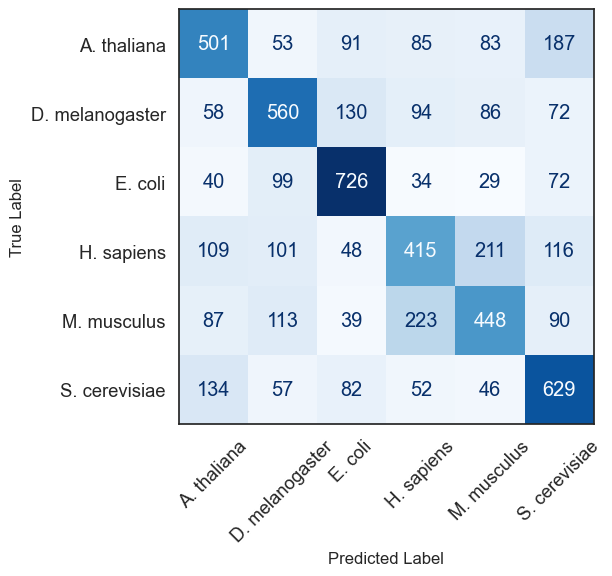

In [4]:
lr = LogisticRegression(random_state=SEED)
train_emb, _ = extract_embeddings_from_pipeline(pipe, train_ds, max_length=MAX_LENGTH)
lr.fit(train_emb, tr_labels)

tr_pred = lr.predict(train_emb)
accuracy = compute_accuracy(tr_labels, tr_pred)
print(f"Train Accuracy: {accuracy:.2f}")

fig = plot_confusion_matrix(tr_labels, tr_pred)

Test Accuracy: 0.47


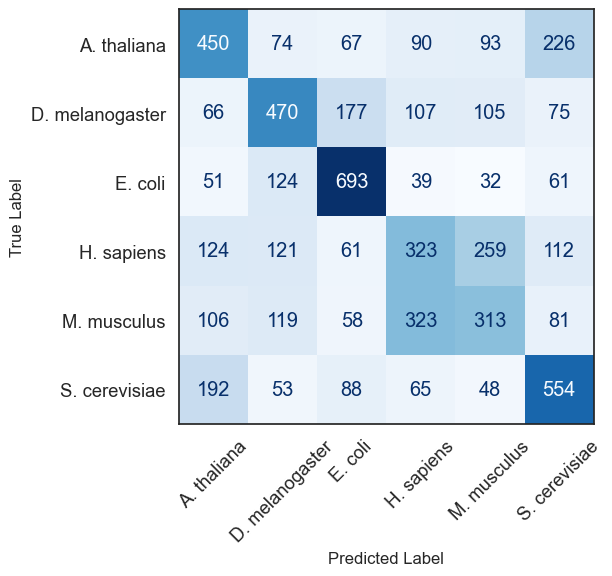

(Random Accuracy: 0.17)


In [5]:
te_pred = lr.predict(test_emb)
accuracy = compute_accuracy(te_labels, te_pred)
print(f"Test Accuracy: {accuracy:.2f}")
fig = plot_confusion_matrix(te_labels, te_pred)
save_fig(fig, "confusion_matrix_test")

random_accuracy = compute_accuracy(te_labels, np.random.permutation(te_labels))
print(f"(Random Accuracy: {random_accuracy:.2f})")

# Fine-tune the model on the training set

## Load model

In [6]:
classif_nt = AutoModelForSequenceClassification.from_pretrained(
    MODEL, num_labels=len(DATASETS), trust_remote_code=True
)

Some weights of the model checkpoint at InstaDeepAI/nucleotide-transformer-v2-50m-multi-species were not used when initializing EsmForSequenceClassification: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing EsmForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing EsmForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at InstaDeepAI/nucleotide-transformer-v2-50m-multi-species and are newly initialized: ['classifier.dense.bias', 'c

## Prepare data

In [7]:
def preprocess(ds):

    def tokenize_batch(batch):
        batch = tokenizer_nt(
            batch["text"],
            padding="longest",
            max_length=MAX_LENGTH,
            truncation=True,
            return_tensors="pt",
        )
        return batch

    tokenized_ds = ds.map(tokenize_batch, batched=True, remove_columns=["text"])

    return tokenized_ds


tokenized_train_ds = preprocess(train_ds)
split = tokenized_train_ds.train_test_split(test_size=VALIDATION_SPLIT_SIZE, seed=SEED)

# train - validation split
tr_train_ds = split["train"]
tr_val_ds = split["test"]

tokenized_test_ds = preprocess(test_ds)

## Prepare trainer

In [8]:
# Freeze the bottom N_LAYERS_TO_FREEZE_FINETUNE transformer layers to speed up / regularize
for param in classif_nt.base_model.embeddings.parameters():
    param.requires_grad = False

for layer_idx, layer_module in enumerate(classif_nt.base_model.encoder.layer):
    if layer_idx < N_LAYERS_TO_FREEZE_FINETUNE:
        for param in layer_module.parameters():
            param.requires_grad = False

# Set up Trainer
training_args = TrainingArguments(
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=N_EPOCHS,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    seed=SEED,
    dataloader_pin_memory=False,  # not supported by mps
)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer_nt)

trainer = Trainer(
    model=classif_nt,
    args=training_args,
    train_dataset=tr_train_ds,
    eval_dataset=tr_val_ds,
    data_collator=data_collator,
    compute_metrics=compute_trainer_metrics,
)

## Train and evaluate

In [9]:
perf = trainer.evaluate(tokenized_test_ds)
print(f"Test accuracy before training: {perf['eval_accuracy']:.2f}")

trainer.train()

perf = trainer.evaluate(tokenized_test_ds)
print(f"Test accuracy after training: {perf['eval_accuracy']:.2f}")

Test accuracy before training: 0.17


Epoch,Training Loss,Validation Loss,Model Preparation Time,Accuracy
1,No log,1.443138,0.001500,0.385000
2,No log,1.369980,0.001500,0.431667
3,No log,1.343096,0.001500,0.428333
4,No log,1.373526,0.001500,0.440000
5,No log,1.412400,0.001500,0.430000
6,1.130800,1.483817,0.001500,0.426667
7,1.130800,1.562356,0.001500,0.408333
8,1.130800,1.606590,0.001500,0.418333
9,1.130800,1.645863,0.001500,0.411667
10,1.130800,1.658619,0.001500,0.408333


Test accuracy after training: 0.45


## Downstream tasks

In [10]:
pipe = DNAClassificationPipeline(model=trainer.model, tokenizer=tokenizer_nt)

test_emb_ft, test_pred_ft = extract_embeddings_from_pipeline(
    pipe, test_ds, max_length=MAX_LENGTH
)

Device set to use mps:0


In [11]:
fig = plot_umap(test_emb_ft, te_labels, seed=SEED)
save_plotly(
    fig,
    "umap_embeddings_ft-model",
    xaxis_attr_dict,
    yaxis_attr_dict,
    PLOTLY_LEGEND_ATTR_DICT,
)

/Users/hclimente/Developer/hclimente.github.io/assets/python/2025-05-02-hf-transformers/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Users/hclimente/Developer/hclimente.github.io/assets/python/2025-05-02-hf-transformers/.venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [12]:
accuracy = compute_accuracy(test_ds["labels"], test_pred_ft.argmax(1))
print(f"Test Accuracy: {accuracy:.2f}")

Test Accuracy: 0.45
